In [136]:
# Imports
import os
import requests
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import seaborn as sns
import hvplot.pandas
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import quantstats as qs
%matplotlib inline

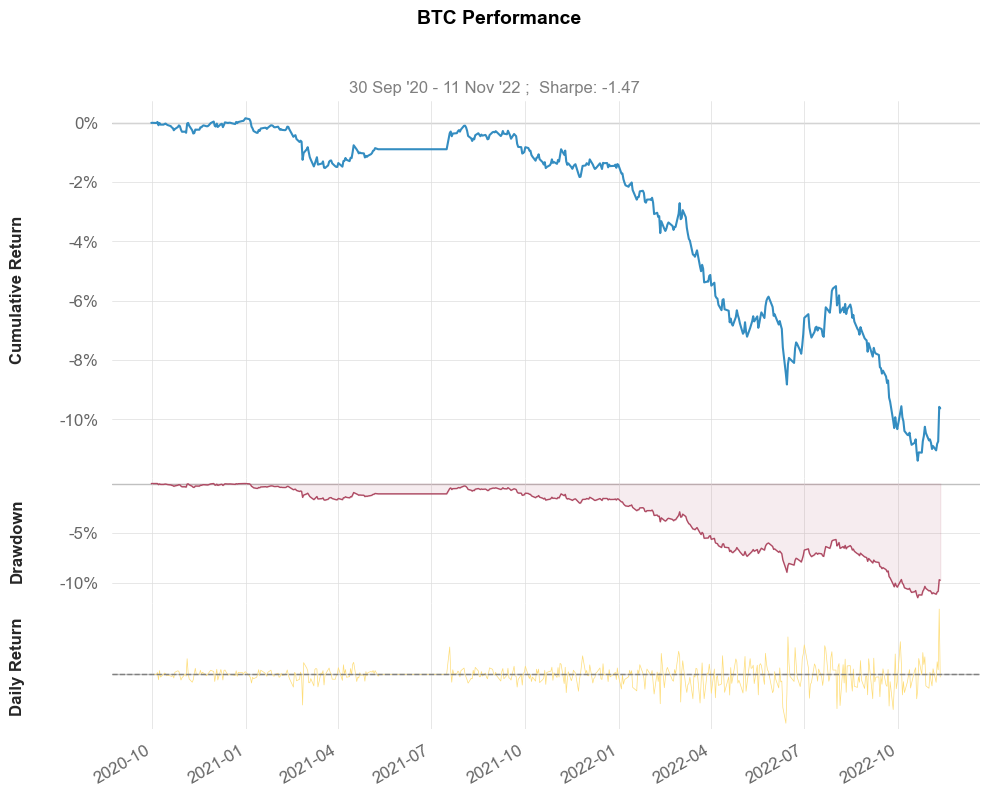

In [137]:
# From library extend pandas functionality with metrics, etc.
qs.extend_pandas()


# fetch the daily returns for a stock
stock = qs.utils.download_returns('BTC')

# show sharpe ratio
qs.stats.sharpe(stock)

# or using extend_pandas()
stock.sharpe()

# Plot 
qs.plots.snapshot(stock, title='BTC Performance')

Date
2020-10-01 00:00:00-04:00         NaN
2020-10-02 00:00:00-04:00    0.000000
2020-10-05 00:00:00-04:00   -0.000050
2020-10-06 00:00:00-04:00    0.000350
2020-10-07 00:00:00-04:00   -0.001100
                               ...   
2022-11-07 00:00:00-05:00   -0.001620
2022-11-08 00:00:00-05:00    0.002501
2022-11-09 00:00:00-05:00    0.000899
2022-11-10 00:00:00-05:00    0.013045
2022-11-11 00:00:00-05:00   -0.000546
Name: Close, Length: 534, dtype: float64

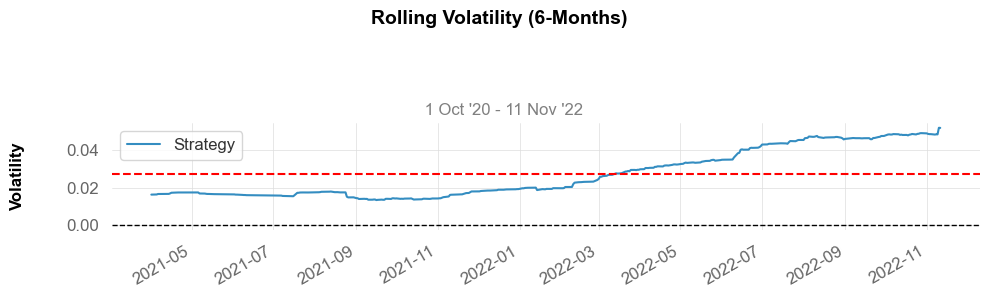

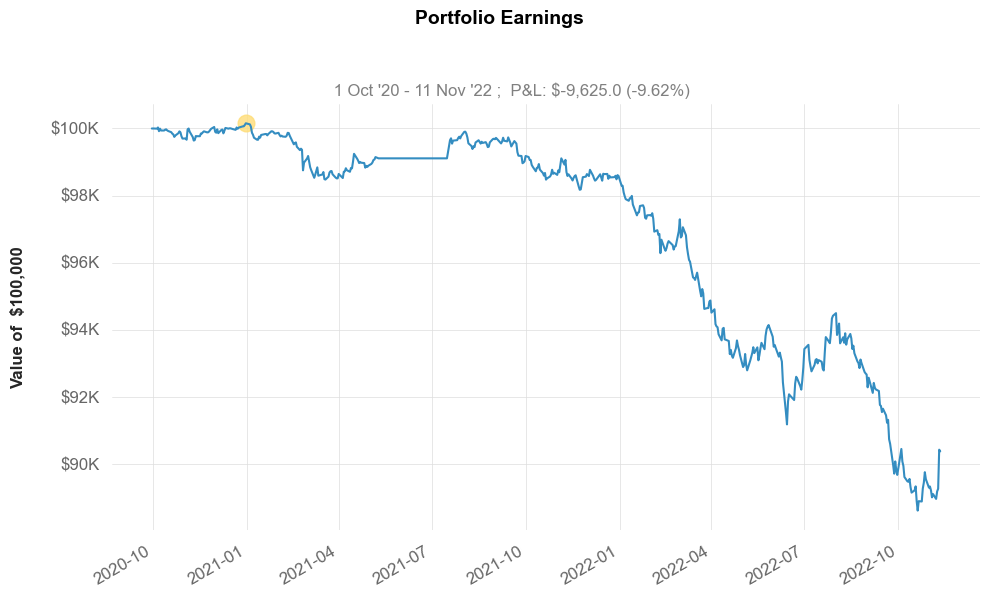

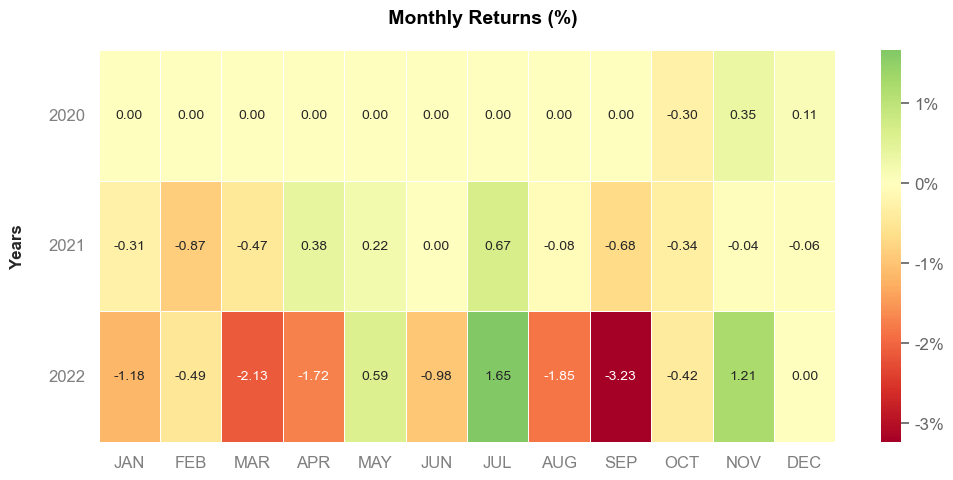

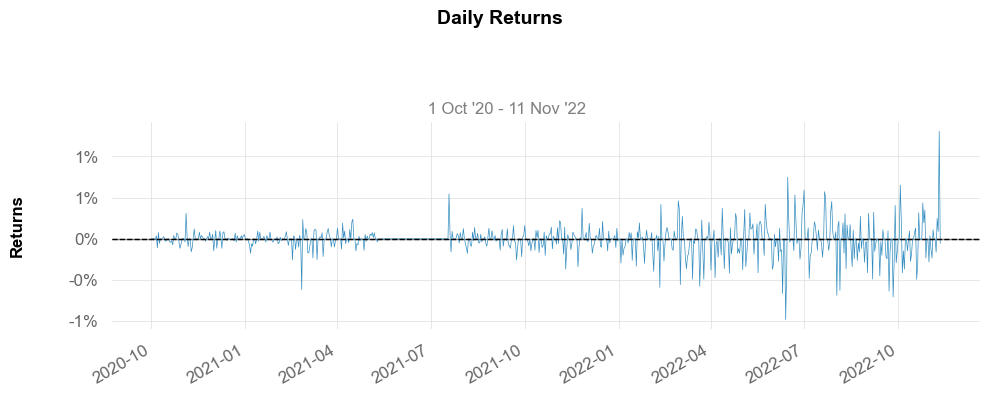

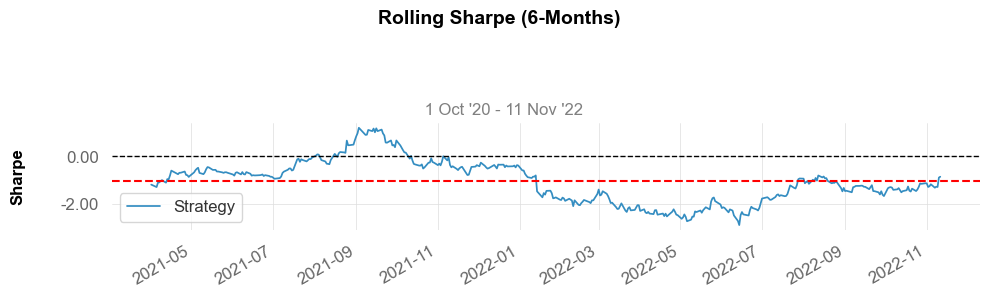

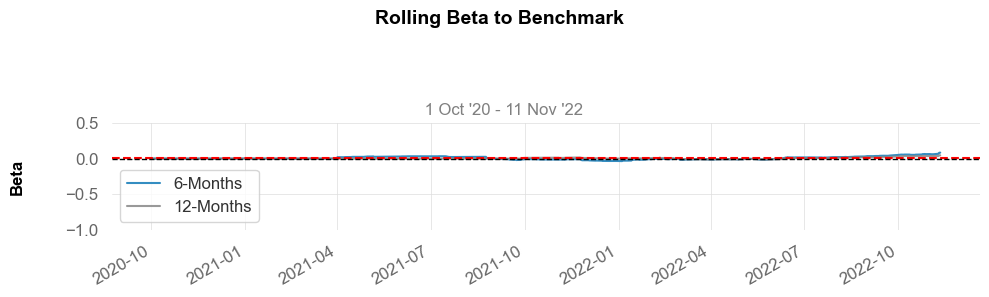

In [138]:
display(stock)
qs.plots.rolling_volatility(stock)

qs.plots.earnings(stock)
qs.plots.monthly_heatmap(stock)
qs.plots.daily_returns(stock)
qs.plots.rolling_sharpe(stock)
qs.plots.rolling_beta(stock, "SPY")


In [139]:
# Load .env enviroment variables
load_dotenv()

True

In [140]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [141]:
# Pulling Crypto Information and store in datframe
# Format current date as ISO format
today = pd.Timestamp("2021-1-1", tz="America/New_York").isoformat()

# Set the tickers BTCUSD (bitcoin), ETHUSD (Ethereum), and TRXUSD (Tron)
tickers = ["BTCUSD", "ETHUSD","TRXUSD"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for crypto

df_crypto = alpaca.get_crypto_bars(
    tickers,
    timeframe,
    start = today
).df


In [142]:
# Reorganize the crypto DataFrame
# Separate ticker data
BTC = df_crypto[df_crypto['symbol']=='BTCUSD'].drop('symbol', axis=1)
BTC['BTC Return'] = BTC['close'].pct_change()
ETH = df_crypto[df_crypto['symbol']=='ETHUSD'].drop('symbol', axis=1)
ETH['ETH Return'] = ETH['close'].pct_change()
TRX = df_crypto[df_crypto['symbol']=='TRXUSD'].drop('symbol', axis=1)
TRX['TRX Return'] = TRX['close'].pct_change()

# Concatenate the ticker DataFrames
df_crypto = pd.concat([BTC, ETH, TRX],axis=1, keys=['BTC','ETH', 'TRX']).dropna()

df_crypto.head()

BTC                                          \
                          exchange      open      high       low     close   
timestamp                                                                    
2021-01-26 06:00:00+00:00     CBSE  32510.82  32584.62  31420.69  31551.72   
2021-01-26 06:00:00+00:00     FTXU  31936.00  32830.00  30900.00  31526.00   
2021-01-27 06:00:00+00:00     CBSE  31556.28  31936.16  29200.00  30407.13   
2021-01-27 06:00:00+00:00     FTXU  31606.00  31719.00  29275.00  31622.00   
2021-01-28 06:00:00+00:00     CBSE  33487.92  34433.04  32729.00  33052.81   

                                                                             \
                                volume trade_count          vwap BTC Return   
timestamp                                                                     
2021-01-26 06:00:00+00:00   4995.55601       56671  31996.651684  -0.022773   
2021-01-26 06:00:00+00:00    455.97410         483  31636.023453  -0.000815   
2021-01-27 06:00:00+00:00  38417.93193      298822  30656.520271  -0.035490   
2021-01-27 06:00:00+00:00   2268.03930         784  30676.961052   0.039953   
2021-01-28 06:00:00+00:00  16333.57023      143680  33787.707047   0.045247   

                               ETH  ...                 TRX            \
                          exchange  ... ETH Return exchange      open   
timestamp                           ...                                 
2021-01-26 06:00:00+00:00     CBSE  ...  -0.041474     FTXU  0.029550   
2021-01-26 06:00:00+00:00     FTXU  ...  -0.003227     FTXU  0.029550   
2021-01-27 06:00:00+00:00     CBSE  ...  -0.032012     FTXU  0.028385   
2021-01-27 06:00:00+00:00     FTXU  ...   0.050961     FTXU  0.028385   
2021-01-28 06:00:00+00:00     CBSE  ...   0.000905     FTXU  0.029725   

                                                                               \
                               high       low     close    volume trade_count   
timestamp                                                                       
2021-01-26 06:00:00+00:00  0.029550  0.028700  0.028700  641654.0         8.0   
2021-01-26 06:00:00+00:00  0.029550  0.028700  0.028700  641654.0         8.0   
2021-01-27 06:00:00+00:00  0.028735  0.028385  0.028735   36045.0         2.0   
2021-01-27 06:00:00+00:00  0.028735  0.028385  0.028735   36045.0         2.0   
2021-01-28 06:00:00+00:00  0.030818  0.029510  0.030818  714424.0         6.0   

                                                
                               vwap TRX Return  
timestamp                                       
2021-01-26 06:00:00+00:00  0.029282  -0.030815  
2021-01-26 06:00:00+00:00  0.029282  -0.030815  
2021-01-27 06:00:00+00:00  0.028385   0.001220  
2021-01-27 06:00:00+00:00  0.028385   0.001220  
2021-01-28 06:00:00+00:00  0.030340   0.072473  

[5 rows x 27 columns]

In [143]:
# Pulling Stock Information and store in datframe
# Format current date as ISO format
today = pd.Timestamp("2021-1-24", tz="America/New_York").isoformat()

# Set the stock_tickers to TSLA , GME, and SPY
stock_tickers = ["TSLA", "GME","SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and GOOGL
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock = alpaca.get_bars(
    stock_tickers,
    timeframe,
    start = today
).df

In [144]:
# Reorganize the stocd DataFrame
# Separate ticker data
TSLA = df_stock[df_stock['symbol']=='TSLA'].drop('symbol', axis=1)
TSLA['TSLA Return'] = TSLA['close'].pct_change().dropna()

GME = df_stock [df_stock['symbol']=='GME'].drop('symbol', axis=1)
GME['GME Return'] = GME['close'].pct_change().dropna()

SPY = df_stock [df_stock['symbol']=='SPY'].drop('symbol', axis=1)
SPY['SPY Return'] = SPY['close'].pct_change().dropna()


# Concatenate the ticker DataFrames
df_stock = pd.concat([TSLA, GME, SPY],axis=1, keys=['TSLA','GME', 'SPY']).dropna()
df_stock.head()

TSLA                                      \
                               open    high       low   close    volume   
timestamp                                                                 
2021-01-26 05:00:00+00:00  891.3800  895.90  871.6000  883.09  23239798   
2021-01-27 05:00:00+00:00  870.3500  891.50  858.6600  864.16  27333955   
2021-01-28 05:00:00+00:00  820.0000  848.00  801.0000  835.43  26383788   
2021-01-29 05:00:00+00:00  830.0003  842.41  780.1000  793.53  35010399   
2021-02-01 05:00:00+00:00  814.2900  842.00  795.5601  839.81  25419892   

                                                                  GME          \
                          trade_count        vwap TSLA Return    open    high   
timestamp                                                                       
2021-01-26 05:00:00+00:00      607303  885.846193    0.002600   88.56  150.00   
2021-01-27 05:00:00+00:00      896055  868.936011   -0.021436  354.83  380.00   
2021-01-28 05:00:00+00:00      935864  831.341042   -0.033246  265.00  483.00   
2021-01-29 05:00:00+00:00     1315023  805.064642   -0.050154  379.71  413.98   
2021-02-01 05:00:00+00:00      817448  823.420381    0.058322  316.56  322.00   

                           ...                            SPY          \
                           ...        vwap GME Return    open    high   
timestamp                  ...                                          
2021-01-26 05:00:00+00:00  ...  122.872824   0.927074  385.41  385.85   
2021-01-27 05:00:00+00:00  ...  316.219003   1.348358  380.22  380.32   
2021-01-28 05:00:00+00:00  ...  290.999661  -0.442894  376.36  381.93   
2021-01-29 05:00:00+00:00  ...  323.206642   0.678719  375.63  376.67   
2021-02-01 05:00:00+00:00  ...  252.238760  -0.307692  373.72  377.34   

                                                                               \
                               low   close     volume trade_count        vwap   
timestamp                                                                       
2021-01-26 05:00:00+00:00  383.540  383.75   42665281      272405  384.407436   
2021-01-27 05:00:00+00:00  372.010  374.65  123351578      712258  376.573606   
2021-01-28 05:00:00+00:00  375.890  377.52   94198104      509965  378.416391   
2021-01-29 05:00:00+00:00  368.270  370.14  126760121      730087  372.205316   
2021-02-01 05:00:00+00:00  370.376  376.02   75817597      414900  374.490318   

                                      
                          SPY Return  
timestamp                             
2021-01-26 05:00:00+00:00  -0.002054  
2021-01-27 05:00:00+00:00  -0.023713  
2021-01-28 05:00:00+00:00   0.007660  
2021-01-29 05:00:00+00:00  -0.019549  
2021-02-01 05:00:00+00:00   0.015886  

[5 rows x 24 columns]

In [145]:
# Monthly returns
sp_data_daily_returns = df_stock['SPY']['close'].pct_change()
sp_data_monthly_returns = df_stock['SPY']['close'].resample('M').ffill().pct_change().dropna()

#convert to Dataframe
sp_data_monthly_returns = pd.DataFrame(sp_data_monthly_returns)
sp_data_monthly_returns.index = sp_data_monthly_returns.index.date
sns.heatmap(sp_data_monthly_returns, annot=True, fmt="", cmap='RdYlGn')

#df_stock_c = df_stock.copy()
#df_stock_c.columns = df_stock_c.columns.droplevel(1)
#df_stock_c
#display(sp_data_monthly_returns)
#fig, ax = plt.subplots(figsize=(14,9))
#plt.title('Dow 30 Heat Map',fontsize=18)
#ax.title.set_position([0.5,1.05])
#ax.set_xticks([])
#sns.heatmap(per_change, annot=True, fmt="", cmap='RdYlGn', ax=ax)
#plt.show()


#sns.heatmap(sp_data_monthly_returns, annot=True, fmt="", cmap='RdYlGn')

In [ ]:
#Combine crypto and stock returns
df_crypto_return =  pd.concat([df_crypto['BTC']['BTC Return'], df_crypto['ETH']['ETH Return'],df_crypto['TRX']['TRX Return']], axis=1)
df_stock_return = pd.concat([df_stock['TSLA']['TSLA Return'], df_stock['GME']['GME Return'], df_stock['SPY']['SPY Return']], axis =1)

# Calculate the log return
df_log_return = np.log(1 + df_crypto_return)
df_log_return_stock = np.log(1 + df_stock_return)

# overlay the two charts
crypto_log = df_log_return.hvplot(title = "Log Return")
stock_log = df_log_return_stock.hvplot()
stock_log * crypto_log

In [ ]:
#df_daily_returns = df.pct_change().dropna()
display(df_crypto_return.tail())
display(df_stock_return.tail())


In [ ]:
# Plot the daily returns
c = df_crypto_return.hvplot(kind="line", title = "Daily Returns")
s = df_stock_return.hvplot(kind="line")
c * s

In [ ]:
#Calculate cumulative returns for crypto and stocks
df_cumulative_returns = (1 + df_crypto_return).cumprod()
df_cumulative_stock_returns = (1 + df_stock_return).cumprod()


# Plot the chart
c = df_cumulative_returns.hvplot(title = "Cumulative Returns")
s = df_cumulative_stock_returns.hvplot()
c*s

In [ ]:
#Plot box chart
c = df_crypto_return.hvplot.box( title = "Daily Return Box", legend = False)
s = df_stock_return.hvplot.box(legend = False)
c*s

In [ ]:
#calculate STDs
all_stds = df_crypto_return.std()
stock_stds = df_stock_return.std()
all_stds = pd.concat([all_stds, stock_stds], axis=0)
all_stds.hvplot.bar(legend = False, title = "STDs")

In [ ]:
#Volatity
volatility = all_stds * np.sqrt(365)
volatility.hvplot.line(title = "Volatility")

In [ ]:
#Plot rolling window
rolling_21 = df_crypto_return.rolling(window=21).std().plot(title = "Crypto Rolling 21 Days Return")

In [ ]:
#Plot rolling window
rolling_21 = df_stock_return.rolling(window=21).std().plot(title = "Stock Rolling 21 Days Return")

In [ ]:
#Calculate correlation and plot heatmap
correlation = df_crypto_return.corr()
corr = df_stock_return.corr()
cor = pd.concat([correlation,corr], axis=1)
sns.heatmap(cor)

In [ ]:
#Calculate GME Rolling Covariance vs SP500
covariance = df_stock_return['GME Return'].cov(df_stock_return['SPY Return'])

variance = df_stock_return['SPY Return'].var()
GME_beta = covariance / variance
rolling_covariance = df_stock_return['GME Return'].rolling(window=21).cov(df_stock_return['SPY Return'])
rolling_covariance.plot(title="GME 21-Day Rolling Covariance vs SP500")

In [ ]:
# Calculate the covariance for TRX and ETH
covariance2 = df_crypto_return['TRX Return'].cov(df_crypto_return['ETH Return'])

variance2 = df_crypto_return['ETH Return'].var()
TRX_beta2 = covariance2 / variance2
rolling_covariance2 = df_crypto_return['TRX Return'].rolling(window=21)

rolling_covariance2 = df_crypto_return['TRX Return'].rolling(window=21).cov(df_crypto_return['ETH Return'])

#Plot the chart
rolling_covariance2.plot(title="TRX 21-Day Rolling Covariance vs ETH")

In [ ]:
#Calculate ewm and plot it
ewm = df_crypto_return.ewm(halflife=21).std().dropna()
ewm.plot()

In [ ]:
def my_rolling_sharpe(y):
    return np.sqrt(126) * (y.mean() / y.std()) # 21 days per month X 6 months = 126

df_c_return = pd.DataFrame()

df_c_return['Rolling Sharpe'] = df_crypto_return['BTC Return'].rolling('180d').apply(my_rolling_sharpe)

df_c_return.plot(y=['Rolling Sharpe'], linewidth=0.5, title = "BTC Rolling Sharpe - 6 Months")

In [ ]:
def my_rolling_sharpe(y):
    return np.sqrt(126) * (y.mean() / y.std()) # 21 days per month X 6 months = 126

df_e_return = pd.DataFrame()

df_e_return['Rolling Sharpe'] = df_crypto_return['ETH Return'].rolling('180d').apply(my_rolling_sharpe)

df_e_return.plot(y=['Rolling Sharpe'], linewidth=0.5, title = "ETH Rolling Sharpe - 6 Months")

In [ ]:
# Calculate the Sharpe ratios
sharpe_crypto_ratios = (df_crypto_return.mean() * 252) / (df_crypto_return.std() * np.sqrt(252))
sharpe_stock_ratios = (df_stock_return.mean() * 252) / (df_stock_return.std() * np.sqrt(252))


# Plot Sharpe ratios for crypto and stocks
c = sharpe_crypto_ratios.hvplot.bar(title = "Sharpe Ratios", hover_fill_color="orange", legend = False)
s = sharpe_stock_ratios.hvplot.bar(hover_color= "orange", legend= False)
c*s